# Finding a new parking location according to out of car report

## Get the data and masking for only no car avalable record

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
rawdata = pd.read_csv('../input/sample_table.csv')
rawdata=rawdata[rawdata['total_cars']==0]
#rawdata=rawdata[:100]
rawdata.head()

,timestamp,latitude,longitude,total_cars,carsList
12,2019-01-10 11:45:55.070781 UTC,32.083175,34.776552,0,[]
13,2019-01-10 11:45:55.070781 UTC,32.088379,34.775111,0,[]
14,2019-01-10 11:45:55.070781 UTC,32.074877,34.773515,0,[]
15,2019-01-10 11:45:55.070781 UTC,32.098603,34.778565,0,[]
16,2019-01-10 11:45:55.070781 UTC,32.094780,34.797280,0,[]


In [2]:
rawdata=rawdata.reset_index(drop=True)
print("Amount of running out of car report : ",len(rawdata))
print("Amount of unique time : ",len(rawdata['timestamp'].unique()))

Amount of running out of car report :  3099723
Amount of unique time :  18998


In [3]:
rawdata.head()

,timestamp,latitude,longitude,total_cars,carsList
0,2019-01-10 11:45:55.070781 UTC,32.083175,34.776552,0,[]
1,2019-01-10 11:45:55.070781 UTC,32.088379,34.775111,0,[]
2,2019-01-10 11:45:55.070781 UTC,32.074877,34.773515,0,[]
3,2019-01-10 11:45:55.070781 UTC,32.098603,34.778565,0,[]
4,2019-01-10 11:45:55.070781 UTC,32.094780,34.797280,0,[]


## Get the location of all report

some of them happend in the same location, so we need to find how many places there are.

In [4]:
locationset=set()
for i in range(len(rawdata)):
    locationset.add((rawdata.latitude[i],rawdata.longitude[i]))
print("Amount of places : ",len(locationset))

Amount of places :  238


In [5]:
locationset=list(locationset)

and also we need a frquency of happening in each places to find where is the best answer for new location.

In [6]:
countfolocation=np.zeros(len(locationset))
for i in range(len(rawdata)):
    countfolocation[locationset.index((rawdata.latitude[i],rawdata.longitude[i]))]+=1
print("First five of frequency count of each location")
countfolocation=list(countfolocation)
print(countfolocation[:5])

First five of frequency count of each location
[18798.0, 16201.0, 14616.0, 14318.0, 10633.0]


#### Filter under 12,000 record out
After I saw the data without filtered it seem used to be record almost every spot of exsited.

So I need to filter it out to focus on most exact high report place.

In [7]:
for i in range(len(countfolocation)-1,-1,-1):
    if countfolocation[i]<12000:
        del countfolocation[i]
        del locationset[i]

### Plot all the location

In [8]:
x=list((locationset[i][0]) for i in range(len(locationset)))
y=list((locationset[i][1]) for i in range(len(locationset)))
import folium      #  folium libraries
from   folium.plugins import MarkerCluster
from statistics import mean
map_world = folium.Map(location=[mean(x), mean(y)], tiles = 'OpenStreetMap', zoom_start = 12)

#  add Locations to map
for i in range(len(x)):
    folium.CircleMarker(
        [x[i], y[i]],
        radius=4*(countfolocation[i]/10000),
        popup=countfolocation[i],
        fill=True,
        color='Red',
        fill_color='Red',
        fill_opacity=0.6
        ).add_to(map_world)

#  display interactive map
map_world

## **Finding the best k for k-mean**

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
X = np.array(list(zip(x, y))).reshape(len(x), 2)
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
#distortions

Useing Elbow graph

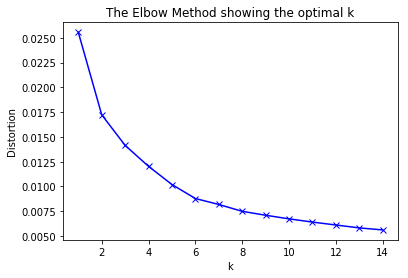

In [10]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

from graph in point k=6 is appropriate because after that point doesn't have a significant changed.

## Apply k-mean model

so now we groupping them to 6 group

In [11]:
kmeanModel = KMeans(n_clusters=6).fit(X)
centers = kmeanModel.cluster_centers_
y_kmeans = kmeanModel.predict(X)
print("The nearest new praking lot location for first five location : ",y_kmeans[:5])

The nearest new praking lot location for first five location :  [1 5 3 3 2]


### Get new parking location 

from center of each group

In [12]:
#print(len(y_kmeans),len(x),len(X))
print("Location of each new parking lot in order index")
print(centers)

Location of each new parking lot in order index
[[32.11202071 34.834323  ]
 [32.09270567 34.78446033]
 [32.05017535 34.76225071]
 [32.07768067 34.77707469]
 [32.1172959  34.80350871]
 [32.06370162 34.7919135 ]]


### Count how many report each spot supported

In [13]:
newstation=np.zeros(6)
for i in range(len(y_kmeans)):
    newstation[y_kmeans[i]]+=countfolocation[i]
print("Counting for the number of the report rely on each new location")
print(newstation)

Counting for the number of the report rely on each new location
[244443. 513000. 237433. 580791. 312707. 389749.]


### Sort the location by their important

The important is measured by how many times this nearby places has been reported

In [14]:
import numpy
sortedstation=(numpy.argsort(newstation))
print("Sorted index by frequency of report near by each location")
print(sortedstation)

Sorted index by frequency of report near by each location
[2 0 4 5 1 3]


The location that comes firt that mean the most worth to invent

In [15]:
sortedcenter=[]
print("Sorted centers weight by high amough of nearby report")
for i in range(len(sortedstation)-1,-1,-1):
    sortedcenter.append(list(centers[sortedstation[i]]))
    print(sortedcenter[len(sortedcenter)-1])
#print(sortedcenter)

Sorted centers weight by high amough of nearby report
[32.077680666666666, 34.77707469047619]
[32.09270566666667, 34.784460333333335]
[32.063701615384616, 34.7919135]
[32.1172959047619, 34.80350871428571]
[32.11202070588235, 34.834323]
[32.050175352941174, 34.76225070588235]


## Plot for new location to park

for plotting the larger spot is the more need to built

In [16]:
map_world = folium.Map(location=[mean(x), mean(y)], tiles = 'OpenStreetMap', zoom_start = 12)

for i in range(len(centers)):
    folium.CircleMarker(
        [sortedcenter[i][0], sortedcenter[i][1]],
        radius=4*(9-i),
        popup=i+1,
        fill=True,
        color='Green',
        fill_color='Green',
        fill_opacity=0.2
        ).add_to(map_world)
    
for i in range(len(centers)):
    folium.CircleMarker(
        [sortedcenter[i][0], sortedcenter[i][1]],
        radius=2,
        popup=i+1,
        fill=True,
        color='Blue',
        fill_color='Blue',
        fill_opacity=0.6
        ).add_to(map_world)
    
map_world